In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -qq "/content/gdrive/MyDrive/u-net.zip"

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
#input layer를 받는 방법
from tensorflow.keras.layers import Input

In [ ]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

#1. 라벨(MASK)를 받는다.

In [ ]:
labels = pd.read_csv('/content/class_dict_seg.csv')
labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


#2. 이미지 데이터 경로와 마스크 경로

In [ ]:
inp_dir = '/content/dataset/semantic_drone_dataset/original_images'

In [ ]:
mask_dir= '/content/RGB_color_image_masks/RGB_color_image_masks'

In [ ]:
import os

#3. 이미지 데이터와 마스크 데이터를 텐서로 변환

In [ ]:
inp_list = os.listdir(inp_dir)
mask_list = os.listdir(mask_dir)

inp_list.sort()
mask_list.sort()

inp_img_list = [os.path.join(inp_dir,i) for i in inp_list]
mask_list = [os.path.join(mask_dir,i) for i in mask_list]

In [ ]:
inp_img_list[0:5]

['/content/dataset/semantic_drone_dataset/original_images/000.jpg',
 '/content/dataset/semantic_drone_dataset/original_images/001.jpg',
 '/content/dataset/semantic_drone_dataset/original_images/002.jpg',
 '/content/dataset/semantic_drone_dataset/original_images/003.jpg',
 '/content/dataset/semantic_drone_dataset/original_images/004.jpg']

In [ ]:
mask_list[0:5]

['/content/RGB_color_image_masks/RGB_color_image_masks/000.png',
 '/content/RGB_color_image_masks/RGB_color_image_masks/001.png',
 '/content/RGB_color_image_masks/RGB_color_image_masks/002.png',
 '/content/RGB_color_image_masks/RGB_color_image_masks/003.png',
 '/content/RGB_color_image_masks/RGB_color_image_masks/004.png']

In [ ]:
# constant 함수를 통해서 이미지 이름 리스트를 상수 텐서로 변환.
# 상수 텐서란? 한번 생성되면 그 값을 변경할 수 없는 텐서를 의미
image_names = tf.constant(inp_img_list)
mask_names = tf.constant(mask_list)

In [ ]:
image_names[0:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'/content/dataset/semantic_drone_dataset/original_images/000.jpg',
       b'/content/dataset/semantic_drone_dataset/original_images/001.jpg',
       b'/content/dataset/semantic_drone_dataset/original_images/002.jpg',
       b'/content/dataset/semantic_drone_dataset/original_images/003.jpg',
       b'/content/dataset/semantic_drone_dataset/original_images/004.jpg'],
      dtype=object)>


```
a = tf.constant([1, 2, 3])

b = tf.constant([4, 5, 6])
```

tf.data.Dataset.from_tensor_slices--> (1,4), (2,5), (3,6)처럼 튜블로 쌍을 이루도록 해준다.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((image_names,mask_names))

In [ ]:
for image,mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/RGB_color_image_masks/RGB_color_image_masks/000.png', shape=(), dtype=string)


In [ ]:
def process_path(image_, mask_):
  #tf.io.read_file---> 텐서플로우를 이용해 파일 입출력을 할 때 사용
  img = tf.io.read_file(image_)
  #img = tf.image.decode_png----> png 파일을 읽는 방법
  img = tf.image.decode_png(img,channels=3)
  #픽셀값을 0과 1사이로 정규화 하는 코드
  img = tf.image.convert_image_dtype(img,tf.float32)

  mask = tf.io.read_file(mask_)
  mask = tf.image.decode_png(mask,channels=3)
  #mask data가 rgb로 주어질 때 전처리 하는 코드
  mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
  return img,mask

def process(image, mask):
  inp_image = tf.image.resize(image,(96,128),method='nearest')
  inp_mask = tf.image.resize(mask,(96,128),method='nearest')

  return inp_image, inp_mask

#tensorflow에서 map 데이터셋에 변환 함수를 적용하는 코드
image_ds = dataset.map(process_path)
processed_images_ds = image_ds.map(process)

#4. 모델링 구조

skip connection 이란? 신경망에서 한 계층의 출력을 그보다 더 높은 계층의 입력과 바로 연결하는 구조를 말합니다. resnet에서 처음으로 제안한 이론인데, 해당 논문을 다 읽어보고 개념에 대해 설명하겠습니다.

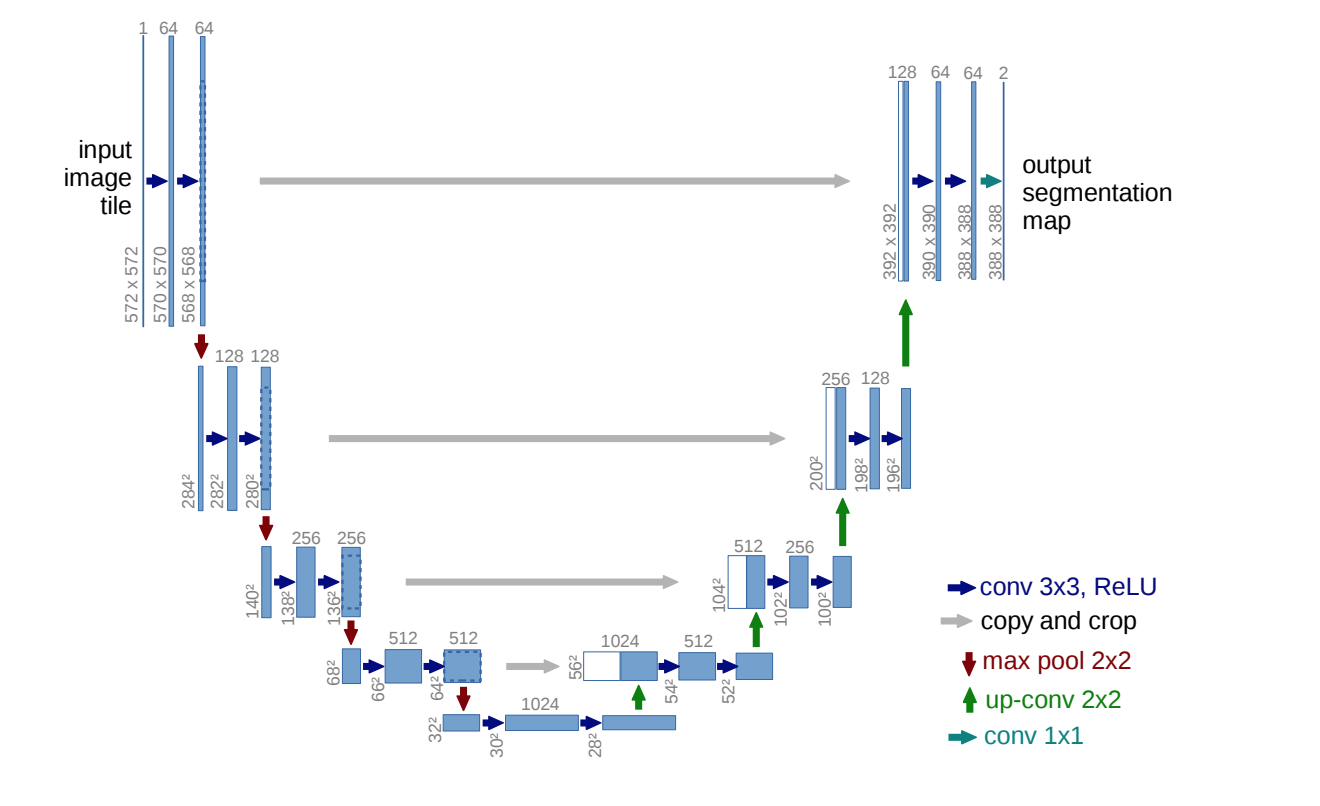

보면 수축 부분이 3* 3conv과 2 * 2maxpooling으로 구성되어 있다는 것을 알 수 있습니다.

그리고 논문을 보면 dropout에 대한 이야기가 나옵니다.



```
 Drop-out layers at the end of the contracting path perform further implicit
data augmentation.
```
즉 수축 부분에 대한 마지막 열에 dropout이 첨부된다는 것을 알 수 있습니다.


In [ ]:
def conv_block(inputs=None, n_filters=64, dropout_prob=0, max_pooling=True):

  conv = Conv2D(n_filters, kernel_size=3,activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
  conv = Conv2D(n_filters, kernel_size=3,activation='relu', padding='same', kernel_initializer='he_normal')(conv)

  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  if max_pooling:
    next_layer = MaxPooling2D(pool_size=(2,2))(conv)

  else:
    next_layer = conv

  skip_connection = conv

  return next_layer, skip_connection


우선 저가 이 부분을 못해서 구현에 실패했던것 같습니다.

여기 레퍼런스를 보면 Conv2DTranspose와 concatenate 함수를 사용합니다.

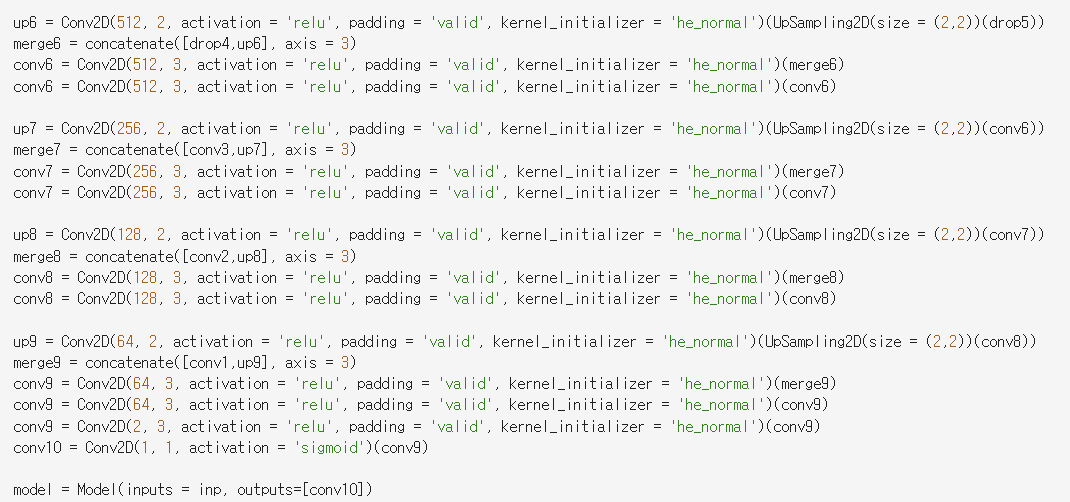

하지만 여기서 저가 구현한 부분을 보면 concatenate함수와 conv로만 구성되어 있습니다. upsampling 과 같은 구조를 처음 구현해봐서 잘못구현했던것 같습니다.

그러니까 정리하자면 일반적인 축소 경로는 cnn + max_pooling으로 구현 가능하지만 확대 경로를 구현하기 위해서는 Conv2DTranspose 함수를 통해 작은 차원의 특징 맵을 원본 크기로 복원해야 합니다. 그리고 concatenate 함수를 통해 축소경로에서 확대경로로 넘어가야 합니다.

그리고 위에 아키텍처 그림을 보시면 upsampling을 하고 다시 2번의 conv2d가 존재합니다. 따라서 마지막 부분에 2개의 conv2d를 적용합니다.

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=64):
  up = Conv2DTranspose(filters=n_filters, kernel_size=(3,3), strides=(2,2), padding='same')(expansive_input)
  merge = concatenate([up, contractive_input], axis=3)
  conv = Conv2D(filters=n_filters, kernel_size = (3,3), activation = 'relu',padding='same',
                 kernel_initializer='he_normal')(merge)
  conv = Conv2D(filters=n_filters, kernel_size = (3,3), activation = 'relu',padding='same',
                 kernel_initializer='he_normal')(conv)

  return conv

또 위에 아키텍처를 보시면 축소 경로 필터가 64에서 배수로 들어납니다. 따라서 이를 n_filter * n으로 구현합니다.

그리고 앞에서 언급 했듯 마지막 층에는 max_pooling이 없고, 대신 dropout이 있습니다.

축소 경로 필터가 64에서 배수로 줄어듭니다. 따라서 이를 n_filter * n으로 구현합니다.

그리고 모델의 마지막 레이어는 1 * 1 로 구성되어 있습니다.

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=64, n_classes=256):
  inputs = Input(input_size)
  cblock1 = conv_block(inputs, n_filters)
  cblock2 = conv_block(cblock1[0], n_filters*2)
  cblock3 = conv_block(cblock2[0], n_filters*4)
  cblock4 = conv_block(cblock3[0], n_filters*8)
  cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.5, max_pooling=False)

  ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
  ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
  ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
  ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

  conv10 = Conv2D(n_classes, 1, padding='same')(ublock9)


  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 64)  36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 64)   0           ['conv2d_1[0][0]']           

논문에 따르면 옵티마이저로 sgd를 사용합니다.



```
The input images and their corresponding segmentation maps are used to train
the network with the stochastic gradient descent implementation of Caffe
```



In [ ]:
unet.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
processed_images_ds

<_MapDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500

BATCH_SIZE = 64

processed_images_ds.batch(BATCH_SIZE)
train_dataset = processed_images_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_images_ds.element_spec)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))


In [ ]:
model_history = unet.fit(train_dataset,
                         epochs=EPOCHS)

Epoch 1/10
7/7 [==============================] - 217s 535ms/step - loss: 5.3420 - accuracy: 0.0675
Epoch 2/10
7/7 [==============================] - 2s 215ms/step - loss: 4.0794 - accuracy: 0.3761
Epoch 3/10
7/7 [==============================] - 2s 216ms/step - loss: 3.3304 - accuracy: 0.3761
Epoch 4/10
7/7 [==============================] - 2s 215ms/step - loss: 2.9619 - accuracy: 0.3442
Epoch 5/10
7/7 [==============================] - 2s 214ms/step - loss: 2.8364 - accuracy: 0.3066
Epoch 6/10
7/7 [==============================] - 2s 215ms/step - loss: 2.6730 - accuracy: 0.3162
Epoch 7/10
7/7 [==============================] - 2s 215ms/step - loss: 2.5285 - accuracy: 0.3607
Epoch 8/10
7/7 [==============================] - 2s 215ms/step - loss: 2.5451 - accuracy: 0.3369
Epoch 9/10
7/7 [==============================] - 2s 215ms/step - loss: 2.4947 - accuracy: 0.3179
Epoch 10/10
7/7 [==============================] - 2s 215ms/step - loss: 2.5431 - accuracy: 0.3147
